In [15]:
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from random import randint
from os import listdir
from PIL import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

dataset_file = 'Dataset/dataset_index.csv'
textures_file = 'Dataset/textures_index.csv'
fruits_path = 'Dataset/fruits-360'
textures_path = 'Dataset/textures'

In [16]:
names = []
for fruit_class in os.listdir(os.path.join(fruits_path, 'Training')):
    names.append(str(fruit_class))

In [17]:
if (not os.path.isfile(dataset_file)):  
    folders_to_add = ['Training', 'Validation']

    df = pd.DataFrame(columns=['Class', 'Path'])

    for folder in folders_to_add:
        if 'DS' not in folder:
            for fruit_class in os.listdir(os.path.join(fruits_path, folder)):
                if 'DS' not in fruit_class:
                    for name in os.listdir(os.path.join(fruits_path, folder, fruit_class)):
                        df = df.append({'Class': str(fruit_class), 'Path': str(os.path.join(fruits_path,folder, fruit_class, name))}, ignore_index=True )
    df.to_csv(dataset_file, index=False)
    del(df)

if (not os.path.isfile(textures_file)):
    df = pd.DataFrame(columns=['Path'])

    for t in os.listdir(textures_path):
        df = df.append({'Path': str(os.path.join(textures_path,t))}, ignore_index=True )
    df.to_csv(textures_file, index=False)
    
    del(df)

In [18]:
class FruitsDataset(Dataset):
    """Fruits dataset."""

    def __init__(self, csv_file, cl, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        aux = pd.read_csv(csv_file)
        self.fruits_idx = aux[aux['Class'] == cl]
        self.transform = transform

    def __len__(self):
        return len(self.fruits_idx)

    def __getitem__(self, idx):
        img_name = self.fruits_idx.iloc[idx, 1]
        image = io.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image
    
class TexturesDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.textures = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.textures)

    def __getitem__(self, idx):
        img_name = self.textures.iloc[idx, 0]
        image = io.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image

In [53]:
class ChangeBackground(object):


    def __init__(self, textures):
        self.textures = textures

    '''
    def __call__(self, image):
        h, w = image.shape[:2]
        maxvals = len(self.textures)
        text_idx = randint(0,maxvals-1) 
        result = self.textures[text_idx] # random selection of the textures
        image = np.where(image >= [240, 240, 240], self.textures[text_idx], image)
        return image'''
    
    def __call__(self, image):
        maxvals = len(self.textures)
        text_idx = randint(0,maxvals-1) # random selection of the texture background
        result = self.textures[text_idx] # adquisition of the background
        h_res, w_res = result.shape[:2]
        # We resize our image to be 1/4
        nsize = randint(int(h_res / 4), int(h_res))
        #img = Image(image)
        img = Image.fromarray(image)
        img = img.resize((nsize,nsize), Image.ANTIALIAS)
        image = np.array(img)
        h_img, w_img = image.shape[:2]
        # Generate random position (1/4 outside include) 
        start_res_x = randint(int(-h_img/2), int(h_res-h_img/2))
        start_res_y = randint(int(-w_img/2), int(w_res-w_img/2))
        end_res_x = start_res_x + h_img
        end_res_y = start_res_y + w_img
        # Fix too far left
        if start_res_x < 0:
            start_img_x = -start_res_x
            start_res_x = 0
        else:
            start_img_x = 0
        # Fix too far top
        if start_res_y < 0:
            start_img_y = -start_res_y
            start_res_y = 0
        else:
            start_img_y = 0
        # Fix too far right
        if end_res_x > h_res:
            end_res_x = h_res
            end_img_x = (end_res_x-start_res_x)
        else:
            end_img_x = h_img
        # Fix too far bottom
        if end_res_y > w_res:
            end_res_y = w_res
            end_img_y = (end_res_y-start_res_y)
        else:
            end_img_y = w_img
        # Write our image in the positions selected
        result[start_res_x:end_res_x,start_res_y:end_res_y] = \
            np.where(image[start_img_x:end_img_x,start_img_y:end_img_y] >= [240,240,240], \
            result[start_res_x:end_res_x,start_res_y:end_res_y], image[start_img_x:end_img_x,start_img_y:end_img_y])
        return result

In [54]:
fruits_avocado = FruitsDataset(csv_file=dataset_file, cl='Avocado')
fruits_orange = FruitsDataset(csv_file=dataset_file, cl='Orange')
textures = TexturesDataset(csv_file=textures_file)
test = FruitsDataset(csv_file=dataset_file, cl='Avocado', transform = transforms.Compose([ChangeBackground(textures)]))

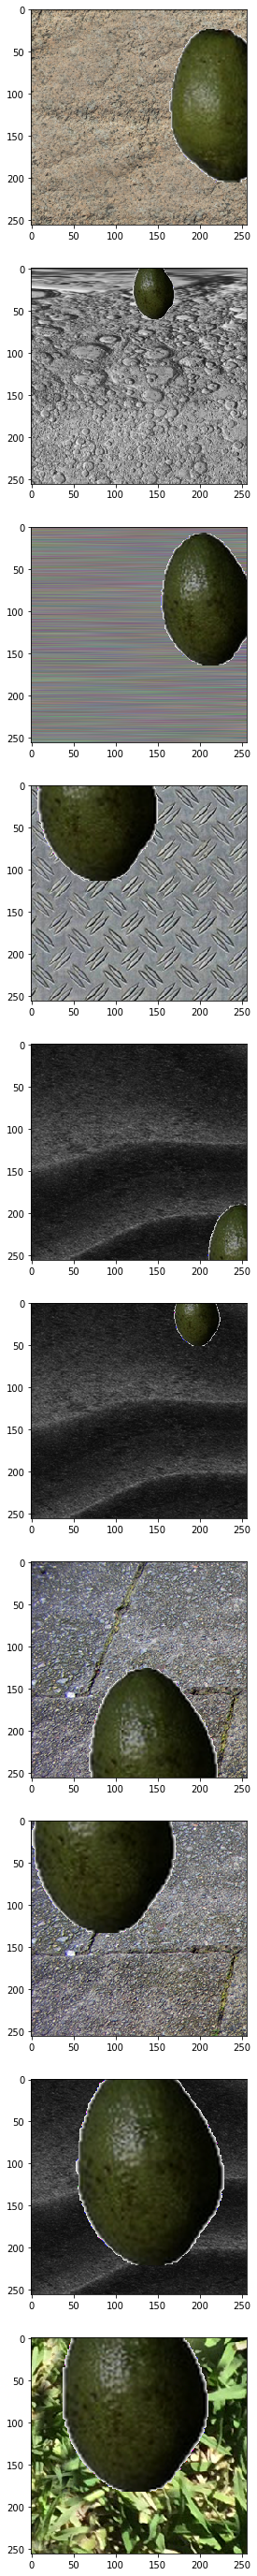

In [55]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(15,50))

for i in range(len(test)):
    sample = test[i]
    ax[i].imshow(sample)
    if i == 9:
        plt.show()
        break

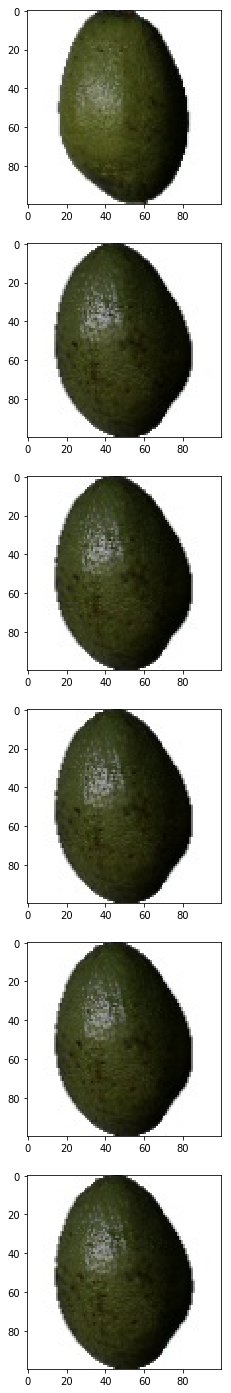

In [8]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10,25))

for i in range(len(fruits_avocado)):
    sample = fruits_avocado[i]
    ax[i].imshow(sample)
    if i == 5:
        plt.show()
        break

In [9]:
#fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(10,25))

for i in range(len(textures)):
    sample = textures[i]
    print(sample.shape)
    #ax[i].imshow(sample[:,:,:])
    if i == 10:
        #plt.show()
        break

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


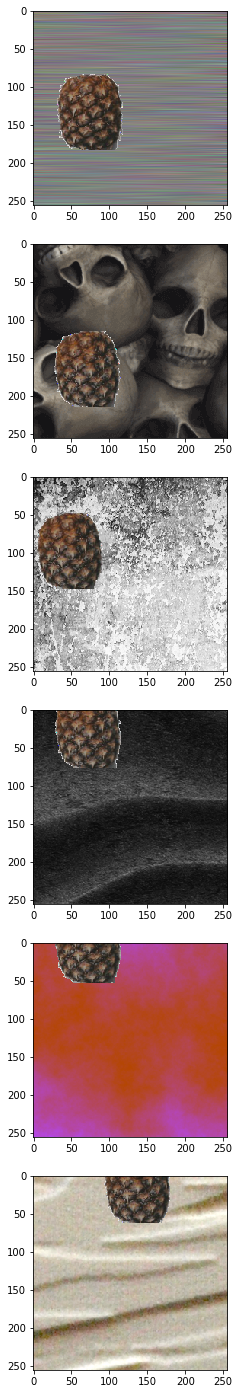

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(10,25))

for i in range(len(test)):
    sample = test[i]
    ax[i].imshow(sample)
    if i == 5:
        plt.show()
        break

In [11]:
import scipy.misc

textures_grans = './Dataset/textures/grans/'
textures_noves = './Dataset/textures/noves/'

i = 12
for name in os.listdir(textures_grans):
    #print(os.path.join(textures_grans,name))
    tmp = scipy.misc.imread(os.path.join(textures_grans,name))
    x, y = tmp.shape[:2]
    if (x > 256 and y > 256):  
        tmp_aux = tmp[:256,:256,:3]
        scipy.misc.imsave(os.path.join(textures_noves,(str(i)+".png")), tmp_aux)
        i = i + 1


FileNotFoundError: [Errno 2] No such file or directory: './Dataset/textures/grans/'

In [24]:
from PIL import Image

In [25]:
img = Image.open("./Dataset/fruits-360/Training/Avocado/0_100.jpg")

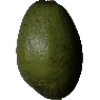

In [26]:
img

In [27]:
nsize = randint(50,256)

In [29]:
img = img.resize((nsize,nsize), Image.ANTIALIAS)

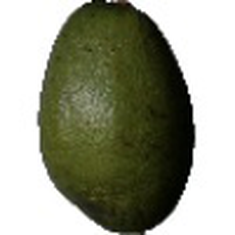

In [30]:
img

In [31]:
a = np.array(img)

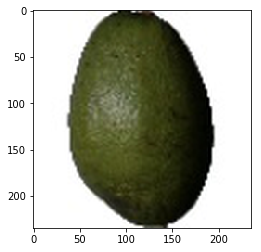

In [34]:
plt.imshow(a)
plt.show()